## Generate AirNow site map based on available measurements
This notebook will loop through the available H(x) IODA files in the period and create the site map based on avaialble measurements of ozone and PM2.5.

In [1]:
import os
import xarray as xr
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
from functions import set_size, get_dates

### Setup the searching period, paths, and figure features. 

In [2]:
tlsize = 12
txsize = 12
mpl.rc('axes', titlesize=tlsize, labelsize=txsize)
mpl.rc('xtick', labelsize=txsize)
mpl.rc('ytick', labelsize=txsize)
mpl.rc('legend', fontsize='small')
axe_w = 4
axe_h = 4
plot_quality = 600

srcpath = '/glade/work/swei/Git/JEDI-METplus'
projection_like = 'wxaq'
minlon = -81.
maxlon = -70
minlat = 39.8
maxlat = 46.

plot_product = 'wrfchem_evaluate'
obs_name = 'airnow-wxaq'

vfhr_range = range(1, 25)
sdate = 2024082200
edate = 2024083100
hint = 24
dates = get_dates(sdate, edate, hint)

hofx_path_tmpl = os.path.join(srcpath, 'output', plot_product, 'hofx', 'f{fhr:02d}', obs_name)
plts_path = os.path.join(srcpath, 'output', plot_product, 'plots', '2dmap', obs_name)

if not os.path.exists(plts_path):
    os.makedirs(plts_path)

# Setup projection
if projection_like == 'wxaq':
    proj = ccrs.LambertConformal(central_longitude=-97.0,
                                 central_latitude=39.0,
                                 standard_parallels=[30., 60.])
if projection_like == 'glb':
    proj = ccrs.PlateCarree()

### Load H(x) IODA files and convert it to Pandas DataFrame.

In [3]:
df = pd.DataFrame()
for idate in tqdm(dates):
    for fhr in vfhr_range:
        hofx_path = hofx_path_tmpl.format(fhr=fhr)
        if not os.path.exists(hofx_path):
            raise Exception(f'HofX folder: {hofx_path} is not available')
        cdate = idate + timedelta(hours=fhr)
        plot_date = cdate.strftime('%Y%m%d%H')
        hofx_file = f'hofx.{obs_name}.{plot_date}.nc4'
        in_hofx = os.path.join(hofx_path, hofx_file)
        if not os.path.exists(in_hofx):
            print(f'WARNING: Skip {plot_date}, {hofx_file} is not available')
            continue

        meta_ds = xr.open_dataset(in_hofx, group='MetaData')
        obsv_ds = xr.open_dataset(in_hofx, group='ObsValue')
        tmpdf = meta_ds.to_dataframe()
        tmpobsdf = obsv_ds.to_dataframe()
        tmpdf = pd.concat((tmpdf, tmpobsdf), axis=1)

        df = pd.concat((df, tmpdf))

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


### Find the sites measure ozone and PM2.5

In [4]:
ozone_df = df[['latitude', 'longitude', 'stationIdentification', 'ozoneInsitu']]
pm2p5_df = df[['latitude', 'longitude', 'stationIdentification', 'particulatematter2p5Insitu']]

ploto3_df = ozone_df.groupby(['stationIdentification']).agg(func='mean').dropna(subset=['ozoneInsitu'])
plotpm_df = pm2p5_df.groupby(['stationIdentification']).agg(func='mean').dropna(subset=['particulatematter2p5Insitu'])

o3_locations = ploto3_df[['longitude', 'latitude']].drop_duplicates()
pm_locations = plotpm_df[['longitude', 'latitude']].drop_duplicates()

### Create the site map with black circles for ozone and blue dots for PM2.5

/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


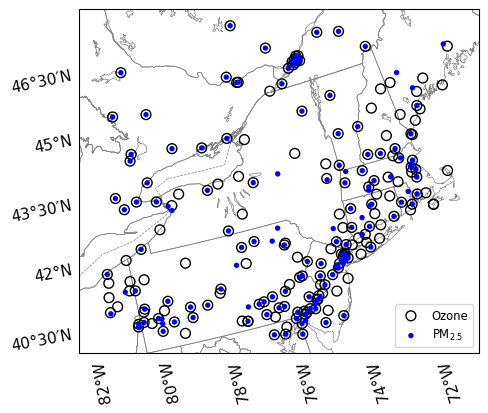

In [5]:
fig = plt.figure()
ax = plt.subplot(projection=proj)
set_size(axe_w, axe_h, t=0.96, l=0.14, b=0.1, r=0.86)
ax.set_extent((minlon, maxlon, minlat, maxlat), crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': txsize - 1}
gl.ylabel_style = {'size': txsize - 1}
gl.right_labels = False
gl.top_labels = False
ax.add_feature(cft.BORDERS.with_scale('10m'), color='grey', linestyle='--', linewidth=0.5)
ax.add_feature(cft.STATES.with_scale('10m'), edgecolor='grey', linewidth=0.5)
ax.add_feature(cft.LAKES.with_scale('10m'), facecolor='none', edgecolor='grey', linewidth=0.5)

ax.scatter(o3_locations['longitude'], o3_locations['latitude'], c='none', s=50,
           edgecolor='k', linewidth=1, transform=ccrs.PlateCarree(), zorder=2, label='Ozone')
ax.scatter(pm_locations['longitude'], pm_locations['latitude'], c='b', s=15,
           edgecolor='none', transform=ccrs.PlateCarree(), zorder=3, label='$\mathrm{PM}_{2.5}$')

ax.legend(loc='lower right')

outname = f'{plts_path}/site_maps.{sdate}_{edate}.png'
fig.savefig(outname, dpi=plot_quality)